In [1]:
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np
import sklearn
import statsmodels as sm

In [2]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

In [30]:
folder_path = Path(r'C:\Users\Shaurya\Downloads') 
csv_file = 'machine_temp_failure_missing.csv'  
date_column = 'timestamp'  

tem_missing = read_dataset(folder_path, csv_file, date_col=date_column)

In [29]:
folder_path1 = Path(r'C:\Users\Shaurya\Downloads') 
csv_file1 = 'machine_temp_failure_original.csv'  
date_column1 = 'timestamp'  

tem_original = read_dataset(folder_path, csv_file, date_col=date_column)

In [31]:
tem_missing

,value
timestamp,
02-12-2013 21:15,73.967322
02-12-2013 21:20,74.935882
02-12-2013 21:25,76.124162
02-12-2013 21:30,78.140707
02-12-2013 21:35,79.329836
...,...
19-02-2014 15:05,98.185415
19-02-2014 15:10,97.804168
19-02-2014 15:15,97.135468


In [32]:
tem_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22695 entries, 02-12-2013 21:15 to 19-02-2014 15:25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   21410 non-null  float64
dtypes: float64(1)
memory usage: 354.6+ KB


In [ ]:
#there are "22695-21410" missing values

In [33]:
tem_missing.describe()

,value
count,21410.000000
mean,85.968188
std,13.553070
min,2.084721
25%,83.082867
50%,89.251290
75%,93.910748
max,108.510543


In [34]:
tem_missing["temperature"] = tem_missing["value"]

In [35]:
tem_missing = tem_missing.drop("value", axis=1)

In [36]:
tem_missing['delta_temperature'] = tem_missing['temperature'].shift(-1) - tem_missing['temperature']

In [37]:
tem_missing

,temperature,delta_temperature
timestamp,,
02-12-2013 21:15,73.967322,0.968560
02-12-2013 21:20,74.935882,1.188280
02-12-2013 21:25,76.124162,2.016546
02-12-2013 21:30,78.140707,1.189128
02-12-2013 21:35,79.329836,-0.619417
...,...,...
19-02-2014 15:05,98.185415,-0.381246
19-02-2014 15:10,97.804168,-0.668700
19-02-2014 15:15,97.135468,0.921384


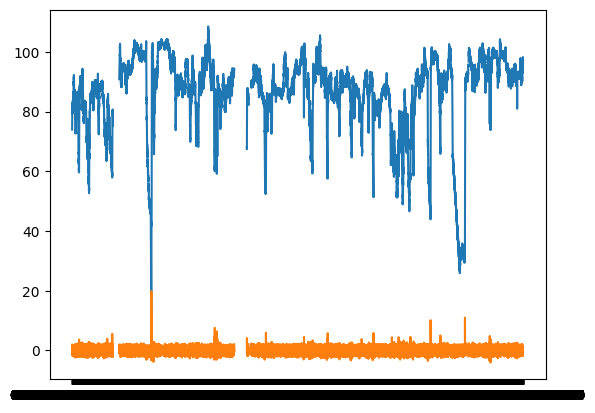

In [39]:
plt.plot(tem_missing["temperature"])
plt.plot(tem_missing["delta_temperature"])

In [43]:
import hvplot.pandas


In [61]:
tem_missing.hvplot.line(x='timestamp', y='temperature')

:Curve   [timestamp]   (temperature)

In [45]:
tem_missing.hvplot.line(x='timestamp', y='delta_temperature')

:Curve   [timestamp]   (delta_temperature)

In [48]:

tem_missing['color'] = tem_missing['temperature'].apply(lambda x: 'red' if x > 70.00 else 'blue')


tem_missing.hvplot.scatter(x='timestamp', y='temperature', color='color', xlabel='X-axis label', ylabel='Temperature', title='Temperature Plot')



:Scatter   [timestamp]   (temperature,color)

In [58]:
tem_missing = tem_missing.drop("color", axis=1)

In [50]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

In [51]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [53]:
tem_missing.isnull().sum()

temperature          1285
delta_temperature    1315
color                   0
dtype: int64

In [62]:
tem_missing["ffill"] = tem_missing["temperature"].fillna(method="ffill")
tem_missing["bfill"] = tem_missing["temperature"].fillna(method="bfill")
tem_missing["mean"] = tem_missing["temperature"].fillna(tem_missing["temperature"].mean())

In [65]:
from sklearn.impute import SimpleImputer


In [66]:
strategy = [('Median Strategy', 'median'),('Most Frequent Strategy', 'most_frequent')]

In [67]:
tem_vals = tem_missing['temperature'].values.reshape(-1,1)

In [68]:
for strategy_name,strategies in strategy:
    tem_missing[strategy_name] = (SimpleImputer(strategy=strategies).fit_transform(tem_vals))